# Build Named Entity Recognation Model with BERT

# **Objective**

The objective of this notebook is to be able to build ner  model using BERT for the given dataset .

The main section of this notebook organize as follows:

- Load NER Data from kaggle.
- Select the relevant columns.
- Identify unique entity tagers in the dataset.
- Remove Duplicate Sentences.
- Finetune Bert Model
- Apply the model to a new sentences.
- Conclusion
- Acknowledgements


# Imports and Setup

In [ ]:
import pandas as pd
import numpy as np
pd.set_option('max_colwidth',150)
import matplotlib.pyplot as plt
import seaborn as sns
import re
import pickle
import os
from tqdm import tqdm, trange
from IPython.core.interactiveshell import InteractiveShell
%matplotlib inline

# Download the Datasets

In [ ]:
pathdir = "/content/data"

In [ ]:
# def download_dataset():
  
#   if not os.path.isfile('ner.csv'):

#     # Downloading Annotated Corpus for Named Entity Recognition dataset
#     !gdown https://drive.google.com/uc?id=13y8JNgL5TQ4x-yufpBOv3QBsEiE051sE

#   if not os.path.exists(pathdir):
#     # Make a data folder to store the data
#     !mkdir data

#     !mv /content/ner.csv ./data


In [ ]:
# download_dataset()

# Load Data

In [ ]:
#specify the path to data location

filepath = '/content/ner.csv'
data = pd.read_csv(filepath, encoding = "latin1", on_bad_lines='skip')


In [ ]:
#Verify that the data is loaded correctly
data.head()

,Unnamed: 0,lemma,next-lemma,next-next-lemma,next-next-pos,next-next-shape,next-next-word,next-pos,next-shape,next-word,...,prev-prev-lemma,prev-prev-pos,prev-prev-shape,prev-prev-word,prev-shape,prev-word,sentence_idx,shape,word,tag
0,0,thousand,of,demonstr,NNS,lowercase,demonstrators,IN,lowercase,of,...,__start2__,__START2__,wildcard,__START2__,wildcard,__START1__,1.0,capitalized,Thousands,O
1,1,of,demonstr,have,VBP,lowercase,have,NNS,lowercase,demonstrators,...,__start1__,__START1__,wildcard,__START1__,capitalized,Thousands,1.0,lowercase,of,O
2,2,demonstr,have,march,VBN,lowercase,marched,VBP,lowercase,have,...,thousand,NNS,capitalized,Thousands,lowercase,of,1.0,lowercase,demonstrators,O
3,3,have,march,through,IN,lowercase,through,VBN,lowercase,marched,...,of,IN,lowercase,of,lowercase,demonstrators,1.0,lowercase,have,O
4,4,march,through,london,NNP,capitalized,London,IN,lowercase,through,...,demonstr,NNS,lowercase,demonstrators,lowercase,have,1.0,lowercase,marched,O


In [ ]:
#totally the data have 1050795 rows and 25 columns
data.shape

(1050795, 25)

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1050795 entries, 0 to 1050794
Data columns (total 25 columns):
 #   Column           Non-Null Count    Dtype  
---  ------           --------------    -----  
 0   Unnamed: 0       1050795 non-null  int64  
 1   lemma            1050795 non-null  object 
 2   next-lemma       1050795 non-null  object 
 3   next-next-lemma  1050795 non-null  object 
 4   next-next-pos    1050795 non-null  object 
 5   next-next-shape  1050795 non-null  object 
 6   next-next-word   1050795 non-null  object 
 7   next-pos         1050795 non-null  object 
 8   next-shape       1050794 non-null  object 
 9   next-word        1050794 non-null  object 
 10  pos              1050794 non-null  object 
 11  prev-iob         1050794 non-null  object 
 12  prev-lemma       1050794 non-null  object 
 13  prev-pos         1050794 non-null  object 
 14  prev-prev-iob    1050794 non-null  object 
 15  prev-prev-lemma  1050794 non-null  object 
 16  prev-prev-pos    1

In [ ]:
data.isnull().sum()

Unnamed: 0         0
lemma              0
next-lemma         0
next-next-lemma    0
next-next-pos      0
next-next-shape    0
next-next-word     0
next-pos           0
next-shape         1
next-word          1
pos                1
prev-iob           1
prev-lemma         1
prev-pos           1
prev-prev-iob      1
prev-prev-lemma    1
prev-prev-pos      1
prev-prev-shape    1
prev-prev-word     1
prev-shape         1
prev-word          1
sentence_idx       1
shape              1
word               1
tag                1
dtype: int64

In [ ]:
data.describe()

,Unnamed: 0,sentence_idx
count,1.050795e+06,1.050794e+06
mean,4.153109e+05,1.898184e+04
std,3.447835e+05,1.576237e+04
min,0.000000e+00,1.000000e+00
25%,1.313490e+05,5.997000e+03
50%,2.626980e+05,1.201700e+04
75%,7.858755e+05,3.592600e+04
max,1.048574e+06,4.795900e+04


# Select the data which contains only Sentence, Word, Pos and tag columns

In [ ]:
ner_data = data[['sentence_idx', 'word', 'pos','tag']]

In [ ]:
ner_data.shape

(1050795, 4)

In [ ]:

ner_data.head()

,sentence_idx,word,pos,tag
0,1.0,Thousands,NNS,O
1,1.0,of,IN,O
2,1.0,demonstrators,NNS,O
3,1.0,have,VBP,O
4,1.0,marched,VBN,O


In [ ]:
ner_data.isnull().sum()

sentence_idx    1
word            1
pos             1
tag             1
dtype: int64

In [ ]:
#drop null value
ner_data = ner_data.dropna()

In [ ]:
# the total number of unique sentence
len(ner_data['sentence_idx'].unique())

35177

In [ ]:
# the total number of unique word
len(ner_data['word'].unique())

30172

In [ ]:
# the total number of unique tag
len(ner_data['tag'].unique())

17

# Remove Duplicated Sentences

In [ ]:
class Build_sentence(object):

    def __init__(self, data):
        self.n_sent = 1
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w, p, t) for w, p, t in zip(s["word"].values.tolist(),
                                                           s["pos"].values.tolist(),
                                                           s["tag"].values.tolist())]
        self.grouped = self.data.groupby("sentence_idx").apply(agg_func)
        self.sentences = [s for s in self.grouped]

    def get_next(self):
        try:
            s = self.grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None

In [ ]:
getter = Build_sentence(ner_data)

In [ ]:
sentences = [[word[0] for word in sentence] for sentence in getter.sentences]
tag = [[tag[2] for tag in tags] for tags in getter.sentences]

for ind in range(len(sentences)):
  sent=' '.join(sentences[ind])
  sent = sent.split('.')[0]
  sentences[ind] = sent.split(" ")
  sentences[ind][-1] = sentences[ind][-1].replace('', '.')

In [ ]:
max=0
for i in range(len(sentences)):
  if len(sentences[i]) > max:
    max = len(sentences[i])
print(max)

92


In [ ]:
labels=[]
for ind in range(len(sentences)):
  labels.append(tag[ind][0:len(sentences[ind])])
print(labels[0])

['O', 'O', 'O', 'O', 'O', 'O', 'B-geo', 'O', 'O', 'O', 'O', 'O', 'B-geo', 'O', 'O', 'O', 'O', 'O', 'B-gpe', 'O', 'O', 'O', 'O', 'O']


In [ ]:
tag_values = list(set(ner_data["tag"].values))
tag_values.append("PAD")
tag2idx = {t: i for i, t in enumerate(tag_values)}
tag2idx

{'I-per': 0,
 'I-gpe': 1,
 'I-eve': 2,
 'I-geo': 3,
 'I-art': 4,
 'B-eve': 5,
 'I-tim': 6,
 'B-gpe': 7,
 'B-geo': 8,
 'B-org': 9,
 'B-tim': 10,
 'B-per': 11,
 'O': 12,
 'I-nat': 13,
 'B-art': 14,
 'I-org': 15,
 'B-nat': 16,
 'PAD': 17}

In [ ]:
tag_values = list(set(ner_data["tag"].values))
tag_values.append("PAD")
idx2tag = {i: t for i, t in enumerate(tag_values)}
idx2tag

{0: 'I-per',
 1: 'I-gpe',
 2: 'I-eve',
 3: 'I-geo',
 4: 'I-art',
 5: 'B-eve',
 6: 'I-tim',
 7: 'B-gpe',
 8: 'B-geo',
 9: 'B-org',
 10: 'B-tim',
 11: 'B-per',
 12: 'O',
 13: 'I-nat',
 14: 'B-art',
 15: 'I-org',
 16: 'B-nat',
 17: 'PAD'}

In [ ]:
tag_values[12]

'O'

In [ ]:
# save idx2tag dictionary using the package pickel 
path_file = '/content/idx2tag.pkl'
pickle.dump(idx2tag, open(path_file, 'wb')) 

# Apply Bert
- Prepare the sentences and labels

In [ ]:
pip install transformers==2.6.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 540 kB 4.1 MB/s 
     |████████████████████████████████| 5.6 MB 32.8 MB/s 
     |████████████████████████████████| 132 kB 64.8 MB/s 
     |████████████████████████████████| 1.3 MB 53.0 MB/s 
     |████████████████████████████████| 880 kB 67.5 MB/s 
     |████████████████████████████████| 79 kB 9.1 MB/s 
     |████████████████████████████████| 9.9 MB 35.3 MB/s 
     |████████████████████████████████| 140 kB 80.2 MB/s 
     |████████████████████████████████| 127 kB 69.6 MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.53-py3-none-any.whl size=895259 sha256=53811b0fa5a699bea43cc69ffa3c4b84f7bcc820e83e860f951b15ca98d687e4
  Stored in directory: /root/.cache/pip/wheels/87/39/dd/a83eeef36d0bf98e7a4d1933a4ad2d660295a40613079bafc9
Successfully built sacremoses
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    U

In [ ]:
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertConfig

from keras_preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

torch.__version__


'1.12.1+cu113'

In [ ]:
# Define maximumn sequence length and batch size
MAX_LEN = 95
bs = 32

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()

In [ ]:
torch.cuda.get_device_name(0)

'Tesla T4'

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased', do_lower_case=True)

Downloading:   0%|          | 0.00/213k [00:00<?, ?B/s]

In [ ]:
# Now we tokenize all sentences. Since the BERT tokenizer is based a Wordpiece tokenizer it will split tokens in subword tokens

def tokenize_and_preserve_labels(sentence, text_labels):
    tokenized_sentence = []
    labels = []

    for word, label in zip(sentence, text_labels):

        # Tokenize the word and count # of subwords the word is broken into
        tokenized_word = tokenizer.tokenize(word)
        n_subwords = len(tokenized_word)

        # Add the tokenized word to the final tokenized word list
        tokenized_sentence.extend(tokenized_word)

        # Add the same label to the new list of labels `n_subwords` times
        labels.extend([label] * n_subwords)

    return tokenized_sentence, labels

In [ ]:
tokenized_texts_and_labels = [tokenize_and_preserve_labels(sent, labs) for sent, labs in zip(sentences, labels)]

In [ ]:
tokenized_texts = [token_label_pair[0] for token_label_pair in tokenized_texts_and_labels]
labels = [token_label_pair[1] for token_label_pair in tokenized_texts_and_labels]

In [ ]:
tokenized_texts[0]

['thousands',
 'of',
 'demons',
 '##tra',
 '##tors',
 'have',
 'marched',
 'through',
 'lo',
 '##ndon',
 'to',
 'protest',
 'the',
 'war',
 'in',
 'i',
 '##ra',
 '##q',
 'and',
 'demand',
 'the',
 'withdrawal',
 'of',
 'br',
 '##itis',
 '##h',
 'troops',
 'from',
 'that',
 'country',
 '.']

In [ ]:
labels[0]

['O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'B-geo',
 'B-geo',
 'O',
 'O',
 'O',
 'O',
 'O',
 'B-geo',
 'B-geo',
 'B-geo',
 'O',
 'O',
 'O',
 'O',
 'O',
 'B-gpe',
 'B-gpe',
 'B-gpe',
 'O',
 'O',
 'O',
 'O',
 'O']

In [ ]:
# cut and pad the token and label sequences to our desired length
input_ids = pad_sequences([tokenizer.convert_tokens_to_ids(txt) for txt in tokenized_texts],
                          maxlen=MAX_LEN, dtype="long", value=0.0,
                          truncating="post", padding="post")


In [ ]:
tags = pad_sequences([[tag2idx.get(l) for l in lab] for lab in labels],
                     maxlen=MAX_LEN, value=tag2idx["PAD"], padding="post",
                     dtype="long", truncating="post")

In [ ]:
# create the mask to ignore the padded elements in the sequences.
attention_masks = [[float(i != 0.0) for i in ii] for ii in input_ids]

# Split the datasets
- split the dataset to use 10% to validate the model.

In [ ]:
tr_inputs, val_inputs, tr_tags, val_tags = train_test_split(input_ids, tags,
                                                            random_state=42, test_size=0.1)
tr_masks, val_masks, _, _ = train_test_split(attention_masks, input_ids,
                                             random_state=42, test_size=0.1)

In [ ]:
len(tr_inputs)

31659

In [ ]:
#  convert the dataset to torch tensors.
tr_inputs = torch.tensor(tr_inputs)
val_inputs = torch.tensor(val_inputs)
tr_tags = torch.tensor(tr_tags)
val_tags = torch.tensor(val_tags)
tr_masks = torch.tensor(tr_masks)
val_masks = torch.tensor(val_masks)

In [ ]:
# define the dataloaders. 
train_data = TensorDataset(tr_inputs, tr_masks, tr_tags)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=bs)

valid_data = TensorDataset(val_inputs, val_masks, val_tags)
valid_sampler = SequentialSampler(valid_data)
valid_dataloader = DataLoader(valid_data, sampler=valid_sampler, batch_size=bs)

# Setup the Bert model for finetuning
- BertForTokenClassification class for token-level predictions.
- BertForTokenClassification is a fine-tuning model that wraps BertModel and adds token-level classifier on top of the BertModel.

In [ ]:
import transformers
from transformers import BertForTokenClassification, AdamW
transformers.__version__

'2.6.0'

In [ ]:
model = BertForTokenClassification.from_pretrained(
    "bert-base-cased",
    num_labels=len(tag2idx),
    output_attentions = False,
    output_hidden_states = False
)

Downloading:   0%|          | 0.00/433 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/436M [00:00<?, ?B/s]

In [ ]:
# pass model parameter to GPU
model.cuda();

In [ ]:
# setup the optimizer and add the parameters it should update
# Add some weight_decay as regularization to the main weight matrices.

FULL_FINETUNING = True
if FULL_FINETUNING:
    param_optimizer = list(model.named_parameters())
    no_decay = ['bias', 'gamma', 'beta']
    optimizer_grouped_parameters = [
        {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.01},
        {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.0}
    ]
else:
    param_optimizer = list(model.classifier.named_parameters())
    optimizer_grouped_parameters = [{"params": [p for n, p in param_optimizer]}]

optimizer = AdamW(
    optimizer_grouped_parameters,
    lr=3e-5,
    eps=1e-8
)

In [ ]:
# add a scheduler to linearly reduce the learning rate throughout the epochs.
from transformers import get_linear_schedule_with_warmup

epochs = 3
max_grad_norm = 1.0

# Total number of training steps is number of batches * number of epochs.
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

In [ ]:
# define evaluation metrics
!pip install seqeval
from seqeval.metrics import f1_score, accuracy_score, precision_score, recall_score

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 43 kB 1.4 MB/s 
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16182 sha256=2693e09cd12b241a69160f87078b12ae25f78d0afb936132b7447e8012075532
  Stored in directory: /root/.cache/pip/wheels/05/96/ee/7cac4e74f3b19e3158dce26a20a1c86b3533c43ec72a549fd7
Successfully built seqeval


## Finetune Bert Model

In [ ]:
## Store the average loss after each epoch so we can plot them.
loss_values, validation_loss_values = [], []

for _ in trange(epochs, desc="Epoch"):
    # ========================================
    #               Training
    # ========================================
    # Perform one full pass over the training set.

    # Put the model into training mode.
    model.train()
    # Reset the total loss for this epoch.
    total_loss = 0

    # Training loop
    for step, batch in enumerate(train_dataloader):
        # add batch to gpu
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        # Always clear any previously calculated gradients before performing a backward pass.
        model.zero_grad()
        # forward pass
        # This will return the loss (rather than the model output)
        # because we have provided the `labels`.
        outputs = model(b_input_ids, token_type_ids=None,
                        attention_mask=b_input_mask, labels=b_labels)
        # get the loss
        loss = outputs[0]
        # Perform a backward pass to calculate the gradients.
        loss.backward()
        # track train loss
        total_loss += loss.item()
        # Clip the norm of the gradient
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(parameters=model.parameters(), max_norm=max_grad_norm)
        # update parameters
        optimizer.step()
        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over the training data.
    avg_train_loss = total_loss / len(train_dataloader)
    print("Average train loss: {}".format(avg_train_loss))

    # Store the loss value for plotting the learning curve.
    loss_values.append(avg_train_loss)


    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    # Put the model into evaluation mode
    model.eval()
    # Reset the validation loss for this epoch.
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0
    predictions , true_labels = [], []
    for batch in valid_dataloader:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch

        # Telling the model not to compute or store gradients,
        # saving memory and speeding up validation
        with torch.no_grad():
            # Forward pass, calculate logit predictions.
            # This will return the logits rather than the loss because we have not provided labels.
            outputs = model(b_input_ids, token_type_ids=None,
                            attention_mask=b_input_mask, labels=b_labels)
        # Move logits and labels to CPU
        logits = outputs[1].detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences.
        eval_loss += outputs[0].mean().item()
        predictions.extend([list(p) for p in np.argmax(logits, axis=2)])
        true_labels.extend(label_ids)

    eval_loss = eval_loss / len(valid_dataloader)
    validation_loss_values.append(eval_loss)
    print("Validation loss: {}".format(eval_loss))
    pred_tags = [tag_values[p_i] for p, l in zip(predictions, true_labels)
                                 for p_i, l_i in zip(p, l) if tag_values[l_i] != "PAD"]
    valid_tags = [tag_values[l_i] for l in true_labels
                                  for l_i in l if tag_values[l_i] != "PAD"]
    print("Validation Accuracy: {}".format(accuracy_score(valid_tags, pred_tags)))
    print("Validation F1-Score: {}".format(f1_score([valid_tags], [pred_tags])))
    print("Precision Score: {}".format(precision_score([valid_tags], [pred_tags])))
    print("Recall Score: {}".format(recall_score([valid_tags], [pred_tags])))
    print()


Epoch:   0%|          | 0/3 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:155: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at  ../torch/csrc/utils/python_arg_parser.cpp:1174.)
  exp_avg.mul_(beta1).add_(1.0 - beta1, grad)


Average train loss: 0.2906156464207052
Validation loss: 0.19834004586393184
Validation Accuracy: 0.9403530555588094
Validation F1-Score: 0.8254750561305515
Precision Score: 0.8214713896457766


Epoch:  33%|███▎      | 1/3 [09:09<18:19, 549.92s/it]

Recall Score: 0.8295179396874313

Average train loss: 0.16679781007796826
Validation loss: 0.18206528838385236
Validation Accuracy: 0.9451908772505242
Validation F1-Score: 0.8377568139937842
Precision Score: 0.8374113377687359


Epoch:  67%|██████▋   | 2/3 [18:27<09:14, 554.20s/it]

Recall Score: 0.838102575390711

Average train loss: 0.1261197534323943
Validation loss: 0.1860737373883074
Validation Accuracy: 0.9451791633965491
Validation F1-Score: 0.8396624472573839
Precision Score: 0.8361344537815126


Epoch: 100%|██████████| 3/3 [27:44<00:00, 554.79s/it]

Recall Score: 0.8432203389830508



# Visualize the training loss

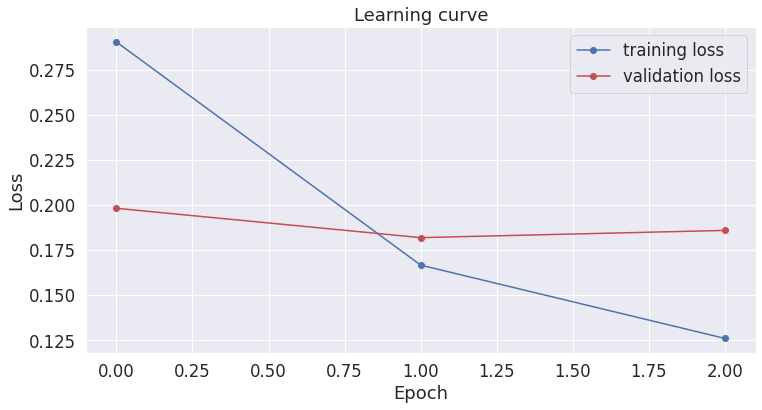

In [ ]:


# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(loss_values, 'b-o', label="training loss")
plt.plot(validation_loss_values, 'r-o', label="validation loss")

# Label the plot.
plt.title("Learning curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.show()


# Apply the model to a new sentence

In [ ]:
test_sentence = """
Kedir is a student at ForthBrain. 
"""

In [ ]:
# first toknize the sentences
tokenized_sentence = tokenizer.encode(test_sentence)
input_ids = torch.tensor([tokenized_sentence]).cuda()

In [ ]:
# run the sentences through the model
with torch.no_grad():
    output = model(input_ids)
label_indices = np.argmax(output[0].to('cpu').numpy(), axis=2)


In [ ]:
# join bpe split tokens
tokens = tokenizer.convert_ids_to_tokens(input_ids.to('cpu').numpy()[0])
new_tokens, new_labels = [], []
for token, label_idx in zip(tokens, label_indices[0]):
    if token.startswith("##"):
        new_tokens[-1] = new_tokens[-1] + token[2:]
    else:
        new_labels.append(tag_values[label_idx])
        new_tokens.append(token)


In [ ]:
for token, label in zip(new_tokens, new_labels):
    print("{}\t{}".format(label, token))


O	[CLS]
B-per	kedir
O	is
O	a
O	student
O	at
B-tim	forthbrain
O	.
O	[SEP]


# Save Model

In [ ]:
model_path = '/content/model.pt'

In [ ]:
torch.save(model, model_path)

In [ ]:
filepath = '/content/model_state/model'

In [ ]:
# torch.save(model.state_dict(), filepath)

# # #Later to restore:
# model.load_state_dict(torch.load(filepath))
# model.eval()

# Load Model

In [ ]:
model_new = torch.load(model_path)
model_predict = model_new.eval()

In [ ]:
test_sentence = """
Kedir Ahmed is a student at forthbrain. 
"""

In [ ]:
# first toknize the sentences
tokenized_sentence = tokenizer.encode(test_sentence)
input_ids = torch.tensor([tokenized_sentence]).cuda()

In [ ]:
# run the sentences through the model
with torch.no_grad():
    output = model_predict(input_ids)
label_indices = np.argmax(output[0].to('cpu').numpy(), axis=2)


In [ ]:
# join bpe split tokens
tokens = tokenizer.convert_ids_to_tokens(input_ids.to('cpu').numpy()[0])
new_tokens, new_labels = [], []
for token, label_idx in zip(tokens, label_indices[0]):
    if token.startswith("##"):
        new_tokens[-1] = new_tokens[-1] + token[2:]
    else:
        new_labels.append(tag_values[label_idx])
        new_tokens.append(token)


In [ ]:
for token, label in zip(new_tokens, new_labels):
    print("{}\t{}".format(label, token))


O	[CLS]
B-per	kedir
I-per	ahmed
O	is
O	a
O	student
O	at
B-org	forthbrain
O	.
O	[SEP]





## Acknowledgements

- The code for NER model is adapted from this online tutorial [Named Entity Recognation with bert ](https://www.depends-on-the-definition.com/named-entity-recognition-with-bert/)